In [58]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

In [59]:
# read the dataset
df = pd.read_csv('fake_job_postings.csv')

# drop rows where discription is missing
df.dropna(subset=['description'], inplace=True)

# Target and features
y = df['fraudulent']
X = df.drop(columns=['fraudulent', 'job_id'])

# Combine all text fields into a single 'combined_text' column
X['combined_text'] = (
    X[['description', 'title', 'company_profile', 'benefits']]
    .fillna('')  # Replace NaNs with empty strings
    .agg(' '.join, axis=1)  # Concatenate the strings
)

numeric_features = ['telecommuting', 'has_company_logo', 'has_questions']
categorical_features = ['employment_type', 'required_experience', 'required_education', 'industry', 'sub_industry']

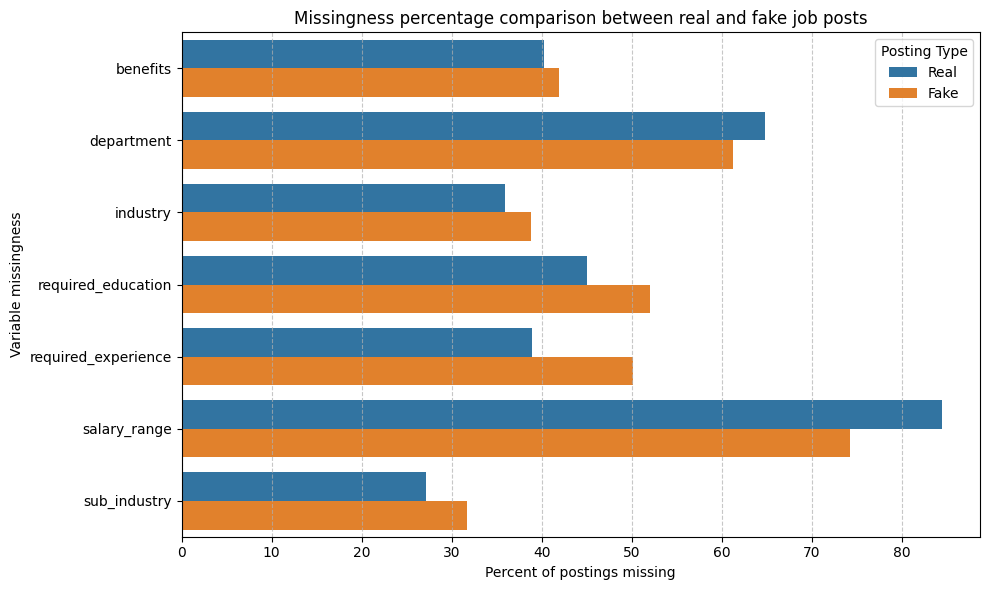

In [60]:
# Select columns with high missingness
high_na_cols = [
    "salary_range", "department", "benefits",
    "required_experience", "required_education", "industry", 'sub_industry',
]

# Create a new DataFrame marking missingness
df_miss = df.copy()
for col in high_na_cols:
    df_miss[f"missing_{col}"] = df_miss[col].isna()

# Reshape to long format
miss_long = df_miss.melt(
    id_vars='fraudulent',
    value_vars=[f"missing_{col}" for col in high_na_cols],
    var_name='variable',
    value_name='is_missing'
)

# Compute missingness percentage per group
pct_table = (
    miss_long
    .groupby(['variable', 'fraudulent'])
    .agg(pct_missing=('is_missing', 'mean'))
    .reset_index()
)
pct_table['pct_missing'] *= 100  # convert to percent
pct_table['variable'] = pct_table['variable'].str.replace('missing_', '', regex=False)
pct_table['fraudulent'] = pct_table['fraudulent'].map({0: 'Real', 1: 'Fake'})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=pct_table, x='pct_missing', y='variable', hue='fraudulent', dodge=True)
plt.xlabel("Percent of postings missing")
plt.ylabel("Variable missingness")
plt.title("Missingness percentage comparison between real and fake job posts")
plt.legend(title="Posting Type")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [61]:
# Define preprocessing steps
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=2000, stop_words='english', lowercase=True,
    token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z]+\b'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'combined_text'),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [62]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14303, 17), (3576, 17), (14303,), (3576,))

In [68]:
# Define parameter grids
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.01, 0.1]
    },
    'SVC': {
        'classifier__C': [0.01, 0.1, 1, 10]
    }
}

In [69]:
# Define models again using the same pipelines
model_pipelines = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
    ]),
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]),
    'XGBoost': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
                                     eval_metric='logloss', random_state=42))
    ]),
    'SVC': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, class_weight='balanced', random_state=42))
    ])
}

In [70]:
# Perform GridSearchCV and fit best models
best_models = {}
for name, model in model_pipelines.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(
        model,
        param_grid=param_grids[name],
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best parameters for {name}: {grid.best_params_}")

Tuning Logistic Regression...
Best parameters for Logistic Regression: {'classifier__C': 10}
Tuning Random Forest...
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Tuning XGBoost...
Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200}
Tuning SVC...
Best parameters for SVC: {'classifier__C': 10}


In [71]:
# Evaluate best models
final_results = {}
f1_scores = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    final_results[name] = {
        'accuracy': acc,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred': y_pred
    }

    f1_scores.append((name, f1))

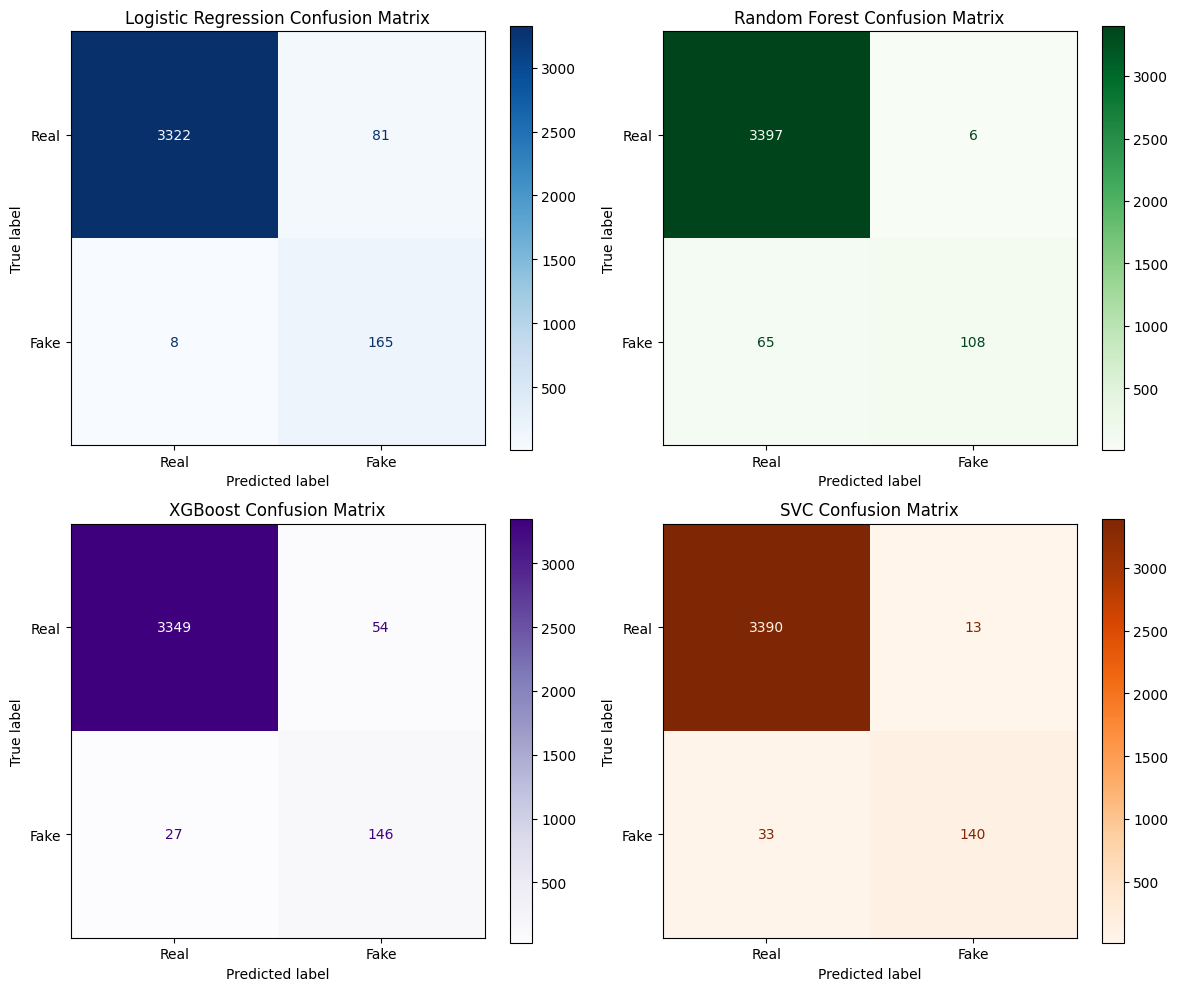

In [72]:
# Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
cmaps = ['Blues', 'Greens', 'Purples', 'Oranges']

for i, (name, result) in enumerate(final_results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot(ax=axes[i], cmap=cmaps[i], values_format='d')
    axes[i].set_title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()

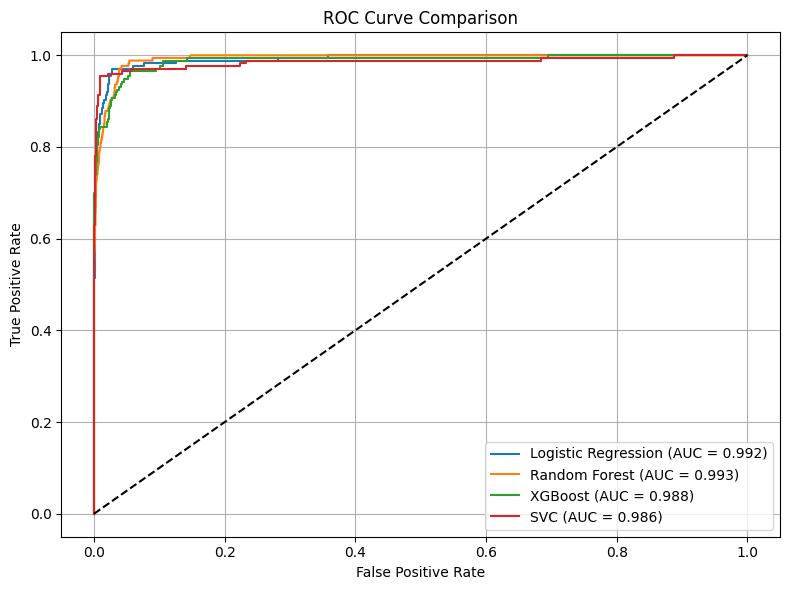

In [73]:
# ROC Curve Plot
plt.figure(figsize=(8, 6))
for name, result in final_results.items():
    plt.plot(result['fpr'], result['tpr'], label=f"{name} (AUC = {result['auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

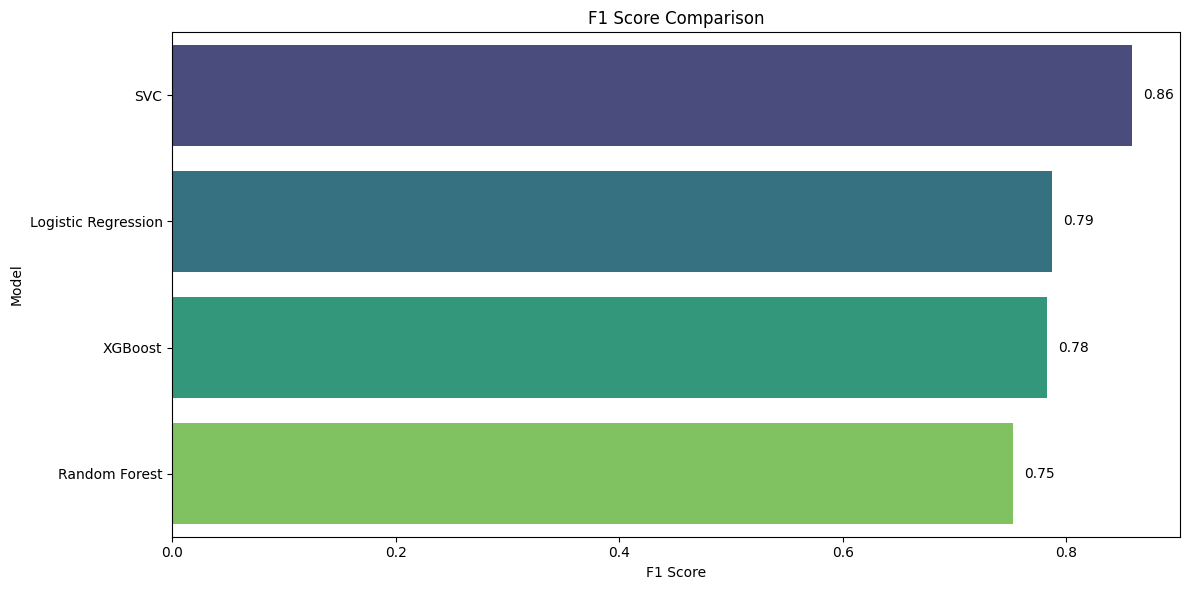

In [74]:
f1_scores.sort(key=lambda x: x[1], reverse=True)
names, scores = zip(*f1_scores)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=scores, y=names, hue=names, palette='viridis', dodge=False)  # disable dodge for one bar per row

# Add text labels
for i, (score, name) in enumerate(zip(scores, names)):
    ax.text(score + 0.01, i, f"{score:.2f}", va='center', ha='left', fontsize=10, color='black')

plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.title("F1 Score Comparison")
plt.tight_layout()
plt.show()